# Demonstration of basic image manipulation with SIRF/CIL
This demonstration shows how to create image data objects for MR, CT and PET and how to work with them.

This demo is a jupyter notebook, i.e. intended to be run step by step.

Author: Kris Thielemans, Richard Brown, Christoph Kolbitsch  
First version: 8th of September 2016  
Second Version: 17th of May 2018  
Third Version: 23rd of October 2019  
Fourth Version: 23rd of April 2021  

CCP SyneRBI Synergistic Image Reconstruction Framework (SIRF).  
Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.  
Copyright 2015 - 2019, 2021 University College London.  
Copyright 2021 Physikalisch-Technische Bundesanstalt.

This is software developed for the Collaborative Computational
Project in Synergistic Reconstruction for Biomedical Imaging
(http://www.ccpsynerbi.ac.uk/).

SPDX-License-Identifier: Apache-2.0

# Initial set-up

In [1]:
# Make sure figures appears inline and animations works
# Edit this to ""%matplotlib notebook" when using the "classic" jupyter notebook interface
%matplotlib widget

In [2]:
# We have placed a file in this directory, notebook_setup.py, which will allow us to import the sirf_exercises library
import notebook_setup

# The sirf_exercises defines some handy tools for these notebooks
from sirf_exercises import cd_to_working_dir

# Initial imports etc
import numpy
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys
import shutil
import brainweb
from tqdm.auto import tqdm

from sirf.Utilities import examples_data_path

## make sure that your installation knows where to read and write data

Later scripts will first have to download data. In addition, the SIRF exercises are set-up to write output in a separate "working directory" to avoid cluttering/overwriting your SIRF files. We need to tell Python where that will be. To do that, you have to run the `download_data.sh` script. You can do that from a terminal, or from this notebook.

The following cell will run the script to simply print a usage message.

In [3]:
%%bash
bash ../../scripts/download_data.sh -h

Usage: ../../scripts/download_data.sh [-p] [-m] [-o] [-d DEST_DIR] [-D DOWNLOAD_DIR] | -h
A script to download specified data for the SIRF-Exercises, as well as
creating Python scripts such that the exercises know where the data is.
  -p        Download  PET data
  -m        Download  MR data
  -o        Download old notebook data
  -h        Print this help
  -d DEST_DIR  Optional destination directory.
               If not supplied, "SIRF_Exercises/data" will be used, i.e., a subdirectory to the repository.
  -D DOWNLOAD_DIR  Optional download directory. Useful if you have the files already downloaded.
                   If not supplied, DEST_DIR will be used.
  -w WORKING_DIR  Optional working directory. Defaults to DEST_DIR/working_folder

Please note that if you run the script multiple times with different values
for the -d or -D options, you might end up with multiple copies of the files.
Running the script without flags will not download data. However, it will create
the Python

Let's now run the script again. The line below will actually not download anything (see further notebooks) but configure the destination directory, which is also used for the "working directory" set-up.

Note that you might want to use the `-d` option to write files somewhere else than the default location. (If you're running this as part of a training session, follow the advice given by your instructors of course!).

In [4]:
%%bash 
bash ../../scripts/download_data.sh

Destination is "/workspaces/SIRF-Exercises/data"
Download location is "/workspaces/SIRF-Exercises/data"
PET data NOT downloaded. If you need it, rerun this script with the -h option to get help.
MR data NOT downloaded. If you need it, rerun this script with the -h option to get help.
Old MR data NOT downloaded. If you need it (unlikely!), rerun this script with the -h option to get help.
Creating /workspaces/SIRF-Exercises/data
Creating data_path.py in /workspaces/SIRF-Exercises/lib/sirf_exercises/data_path.py
download_data.sh script completed.


We can now move to a working directory for this notebook.

In [5]:
cd_to_working_dir('Introductory', 'introduction')

Let's check where we are by using the ipython "magic" command to print the current working directory

In [6]:
%pwd

'/workspaces/SIRF-Exercises/data/working_folder/Introductory/introduction'

# Utilities

First define some handy function definitions to make subsequent code cleaner. You can ignore them when you first see this demo.
They have (minimal) documentation using Python docstrings such that you can do for instance `help(plot_2d_image)`

In [7]:
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.6)
    plt.title(title)
    plt.axis("off")

def crop_and_fill(templ_im, vol):
    """Crop volumetric image data and replace image content in template image object"""
    # Get size of template image and crop
    idim = templ_im.as_array().shape
    # Let's make sure everything is centered. 
    # Because offset is used to index an array it has to be of type integer, so we do an integer division using '//'
    offset = (numpy.array(vol.shape) - numpy.array(idim)) // 2
    vol = vol[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1], offset[2]:offset[2]+idim[2]]
    
    # Make a copy of the template to ensure we do not overwrite it
    templ_im_out = templ_im.clone()
    
    # Fill image content
    templ_im_out.fill(numpy.reshape(vol, idim))
    return(templ_im_out)

Note that SIRF and CIL have their own `show*` functions which will be used on other demos.

# Get brainweb data

We will download and use Brainweb data, which is made more convenient by using the Python brainweb module. We will use a FDG image for PET. MR usually provides qualitative images with an image contrast proportional to difference in T1, T2 or T2* depending on the sequence parameters. Nevertheless, we will make our life easy, by directly using the T1 map provided by the brainweb for MR.

In [8]:
fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)

In [9]:
for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1)

mMR ground truths:   0%|          | 0/1 [00:00<?, ?subject/s]

In [10]:
FDG_arr  = vol['PET']
T1_arr   = vol['T1']
uMap_arr = vol['uMap']

## Display it

The convention for the image dimensions in the brainweb images is [z, y, x]. If we want to
display the central slice (i.e. z), we therefore have to use the 0th dimension of the array.
We are using an integer division using '//' to ensure we can use the value to index the array.

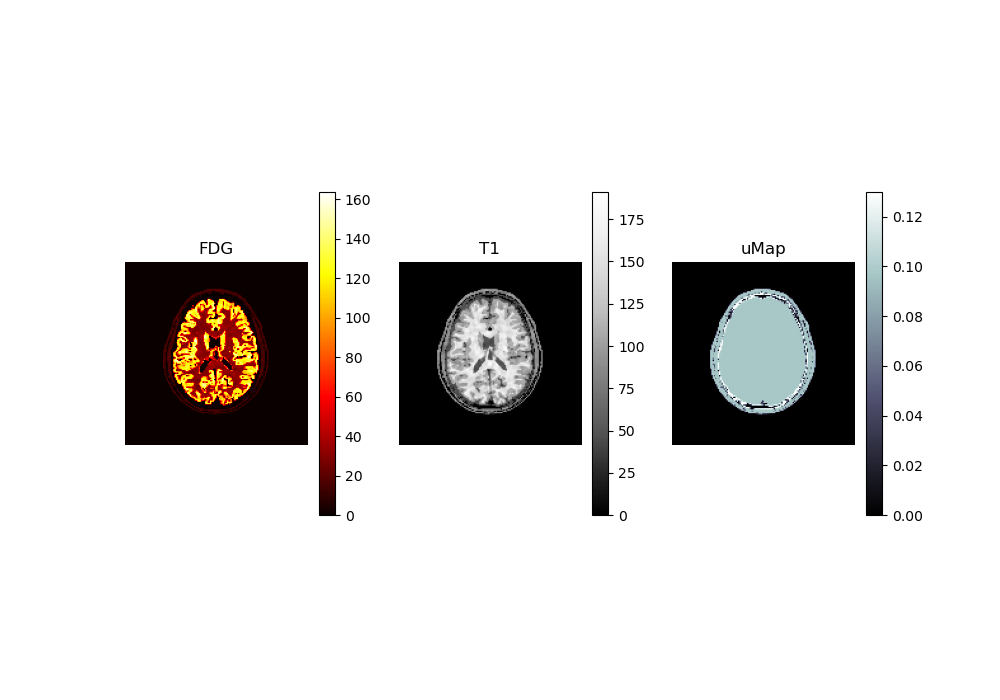

In [19]:
plt.figure();

slice_show = FDG_arr.shape[0]//2

# The images are very large, so we only want to visualise the central part of the image. In Python this can be 
# achieved by using e.g. 100:-100 as indices. This will "crop" the first 100 and last 100 voxels of the array. 
plot_2d_image([1,3,1], FDG_arr[slice_show, 100:-100, 100:-100], 'FDG', cmap="hot")
plot_2d_image([1,3,2], T1_arr[slice_show, 100:-100, 100:-100], 'T1', cmap="Greys_r")
plot_2d_image([1,3,3], uMap_arr[slice_show, 100:-100, 100:-100], 'uMap', cmap="bone")

More than likely, this image came out a bit small for your set-up. You can check the default image size as follows (note: units are inches)

In [20]:
plt.rcParams['figure.figsize']

[10.0, 7.0]

You can then change them to a size more suitable for your situation, e.g.

In [18]:
plt.rcParams['figure.figsize']=[10,7]

Now execute the cell above that plots the images again to see if that helped.

You can make this change permanent by changing your `matplotlibrc` file (this might be non-trivial when running on Docker or JupyterHub instance!). You will need to search for `figure.figsize` in that file. Its location can be found as follows:

In [21]:
import matplotlib
matplotlib.matplotlib_fname()

'/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'

# SIRF/CIL ImageData based on Brainweb

In order to create an __MR__, __PET__ or __CT__ `ImageData` object, we need some information about the modality, the hardware used for scanning and the to some extent also the acquisition and reconstruction process. Most of this information is contained in the raw data files which can be exported from the __MR__ and __PET__ scanners. For __CT__ the parameters can be defined manually.

In the following we will now go through each modality separately and show how a simple `ImageData` object can be created. In the last part of the notebook we will then show examples about how to display the image data with python or how to manipulate the image data (e.g. multiply it with a constant or calculate its norm).

In order to make our life easier, we will assume that the voxel size and image orientation for __MR__, __PET__ and __CT__ are all the same and they are the same as the brainweb data. This is of course not true, real-life applications and/or synergistic image reconstruction we would need to resample the brainweb images before using them as input to the `ImageData` objects.

# MR

Use the 'mr' prefix for all Gadgetron-based SIRF functions.
This is done here to explicitly differentiate between SIRF mr functions and 
anything else.

In [15]:
import sirf.Gadgetron as mr

We'll need a template MR acquisition data object

In [16]:
templ_mr = mr.AcquisitionData(os.path.join(examples_data_path('MR'), 'simulated_MR_2D_cartesian.h5'))

reading from /opt/SIRF-SuperBuild/INSTALL/share/SIRF-3.6/data/examples/MR/simulated_MR_2D_cartesian.h5 using ignore mask 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 

Started reading acquisitions from /opt/SIRF-SuperBuild/INSTALL/share/SIRF-3.6/data/examples/MR/simulated_MR_2D_cartesian.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /opt/SIRF-SuperBuild/INSTALL/share/SIRF-3.6/data/examples/MR/simulated_MR_2D_cartesian.h5


In MR the dimensions of the image data depend of course on the data acquisition but they are also influenced by the reconstruction process. Therefore, we need to carry out an example reconstruction, in order to have all the information about the image.

In [17]:
# Simple reconstruction
preprocessed_data = mr.preprocess_acquisition_data(templ_mr)
recon = mr.FullySampledReconstructor()
recon.set_input(preprocessed_data)
recon.process()
im_mr = recon.get_output()

Message received with ID: 5
Input stream has terminated
Message received with ID: 5
Input stream has terminated


If the above failed with an error 'Server running Gadgetron not accessible', you probably still have to start a Gadgetron server. Check the [DocForParticipants](https://github.com/SyneRBI/SIRF-Exercises/blob/master/DocForParticipants.md#start-a-Gadgetron-server).

Now we have got an MR image object and can fill it with the brainweb data. The dimensions won't fit, but we will simply crop the image.

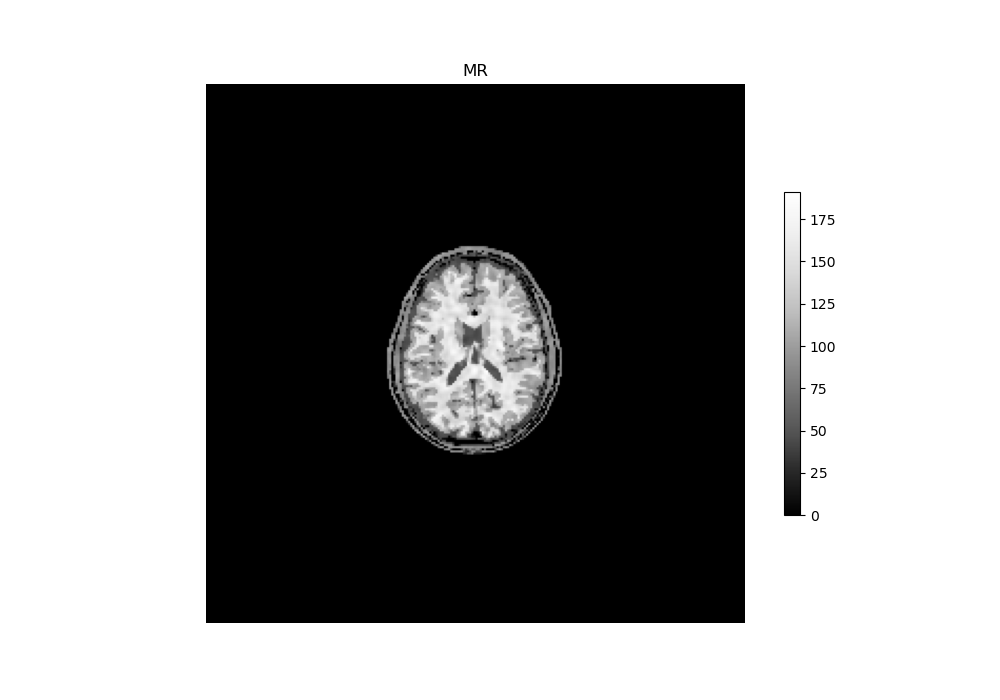

In [18]:
im_mr = crop_and_fill(im_mr, T1_arr)

# im_mr is an MR image object. In order to visualise it we need access to the underlying data array. This is
# provided by the function as_array(). This yields a numpy array which can then be easily displayed. More 
# information on this is also provided at the end of the notebook.
plt.figure();
plot_2d_image([1,1,1], numpy.abs(im_mr.as_array())[im_mr.as_array().shape[0]//2, :, :], 'MR', cmap="Greys_r")

# CT

Use the 'ct' prefix for all CIL-based functions.
This is done here to explicitly differentiate between CIL ct functions and 
anything else.

In [19]:
import cil.framework as ct

Create a template Cone Beam CT acquisition geometry

In [20]:
N = 120
angles = numpy.linspace(0, 360, 50, True, dtype=numpy.float32)
offset = 0.4
channels = 1
ag = ct.AcquisitionGeometry.create_Cone3D((offset,-100, 0), (offset,100,0))
ag.set_panel((N,N-2))
ag.set_channels(channels)
ag.set_angles(angles, angle_unit=ct.AcquisitionGeometry.DEGREE);

Now we can create a template CT image object

In [21]:
ig = ag.get_ImageGeometry()
im_ct = ig.allocate(None)

Now we have got an CT image object and can fill it with the brainweb data. The dimensions won't fit, but we will simply crop the image.

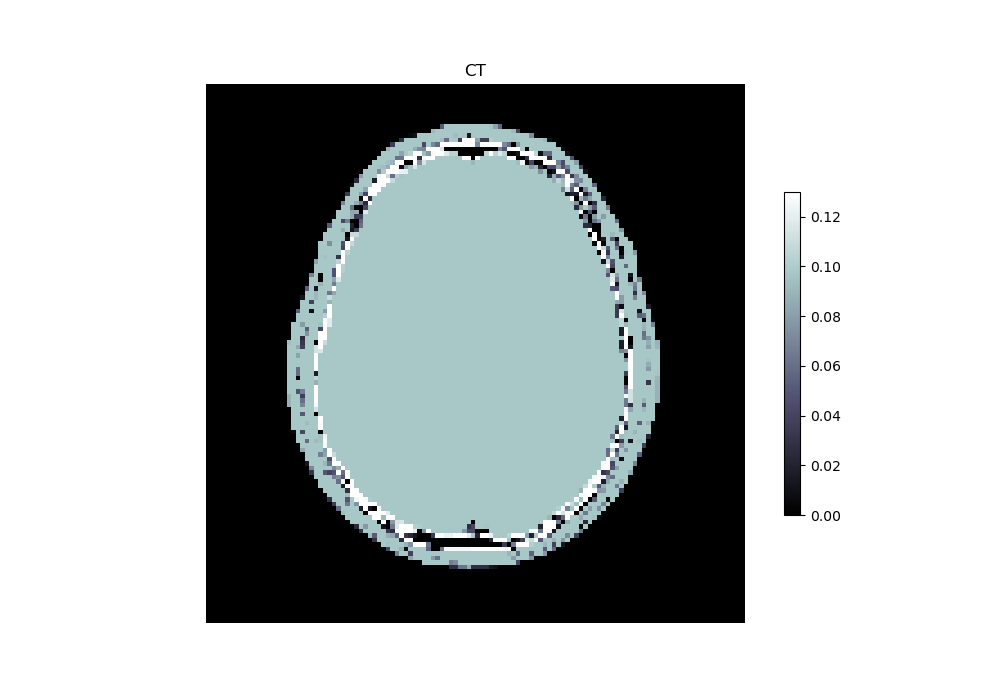

In [22]:
im_ct = crop_and_fill(im_ct, uMap_arr)

plt.figure();
plot_2d_image([1,1,1], im_ct.as_array()[im_ct.as_array().shape[0]//2, :, :], 'CT', cmap="bone")

# PET

Use the 'pet' prefix for all STIR-based SIRF functions.
This is done here to explicitly differentiate between SIRF pet functions and 
anything else.

In [23]:
import sirf.STIR as pet

We'll need a template sinogram

In [24]:
templ_sino = pet.AcquisitionData(os.path.join(examples_data_path('PET'), 'mMR','mMR_template_span11.hs'))


INFO: Setting energy window keys as in STIR3.0


Now we can create a template PET image object that would fit dimensions for that sinogram

In [25]:
im_pet = pet.ImageData(templ_sino)


INFO: Determined voxel size by dividing default_bin_size (2.08626) by zoom


Now we have got a PET image object and can fill it with the brainweb data. The dimensions won't fit, but we will simply crop the image.

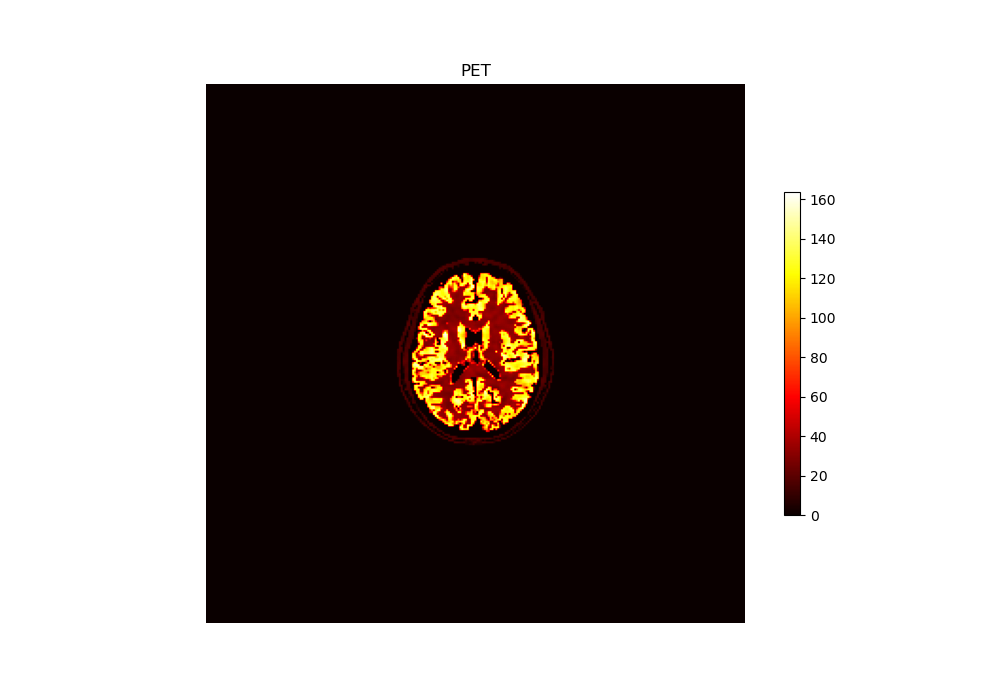

In [26]:
im_pet = crop_and_fill(im_pet, FDG_arr)

plt.figure();
plot_2d_image([1,1,1], im_pet.as_array()[im_pet.as_array().shape[0]//2, :, :], 'PET', cmap="hot")

# Basic image manipulations
Images (like most other things in SIRF and CIL) are represented as *objects*, in this case of type `ImageData`.
In practice, this means that you can only manipulate its data via *methods*.

Image objects contain the actual voxel values, but also information on the number of voxels,
voxel size, etc. There are methods to get this information.

There are additional methods for other manipulations, such as basic image arithmetic (e.g.,
you can add image objects).

Because we created an `ImageData` object for each modality we can now simply select which modality we want to look at. Because SIRF is implemented to make the transition from one modality to the next very easy, many of the *methods* and *attributes* are exactly the same between __MR__, __PET__ or __CT__ . There are of course *methods* and *attributes* which are modality-specific but the basic handling of the `ImageData` objects is very similar between __MR__, __PET__ or __CT__ .

In [27]:
# Make a copy of the image of a specific modality
image_data_object = im_ct.clone()

What is an ImageData?

Images are represented by objects with several methods. The most important method 
is `as_array()` which we'll use below.

In [28]:
# Let's see what all the methods are.
help(pet.ImageData)

Help on class ImageData in module sirf.STIR:

class ImageData(sirf.SIRF.ImageData)
 |  ImageData(arg=None)
 |  
 |  Class for PET image data objects.
 |  
 |  ImageData objects contain both geometric data and the actual voxel
 |  values. You have to use the `as_array` method to get an array with
 |  the voxel values, and use the `fill` function to change the voxel values.
 |  
 |  Method resolution order:
 |      ImageData
 |      sirf.SIRF.ImageData
 |      sirf.SIRF.DataContainer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |      Deallocates this ImageData object.
 |  
 |  __init__(self, arg=None)
 |      Creates an ImageData object.
 |      
 |      Arguments:
 |          arg : Python str or AcquisitionData or None, interpreted as follows:
 |      str            : read the object from a file specified by <arg>
 |                       (the file format has to be support by STIR).
 |      STIR.AcquisitionData: create an object compati

In [29]:
# Use as_array to extract an array of voxel values
# The resulting array as a `numpy` array, as standard in Python.
image_array=image_data_object.as_array()

# We can use the standard `numpy` methods on this array, such as getting its `shape` (i.e. dimensions).
print(image_array.shape)

# Whenever we want to do something with the image-values, we have to do it via this array.
# Let's print a voxel-value roughly in the centre of the object. 
# We will not use the centre because the intensity here happens to be 0.
centre = numpy.array(image_array.shape)//2
print(image_array[centre[0], centre[1]+20, centre[2]+20])

(118, 120, 120)
0.0975


Manipulate the image data for illustration

In [30]:
# Multiply the data with a factor
image_array *= 0.01

# Stick this new data into the original image object.
# (This will not modify the file content, only the variable in memory.)
image_data_object.fill(image_array)
print(image_array[centre[0], centre[1]+20, centre[2]+20])

0.0009749999


You can do basic math manipulations with ImageData objects 
So the above lines can be done directly on the `image` object

In [31]:
image_data_object *= 0.01

# Let's check
image_array=image_data_object.as_array()
print(image_array[centre[0], centre[1]+20, centre[2]+20])

9.749999e-06


Display the middle slice of the image (which is really a 3D volume)
We will use our own `plot_2d_image` function (which was defined above) for brevity.

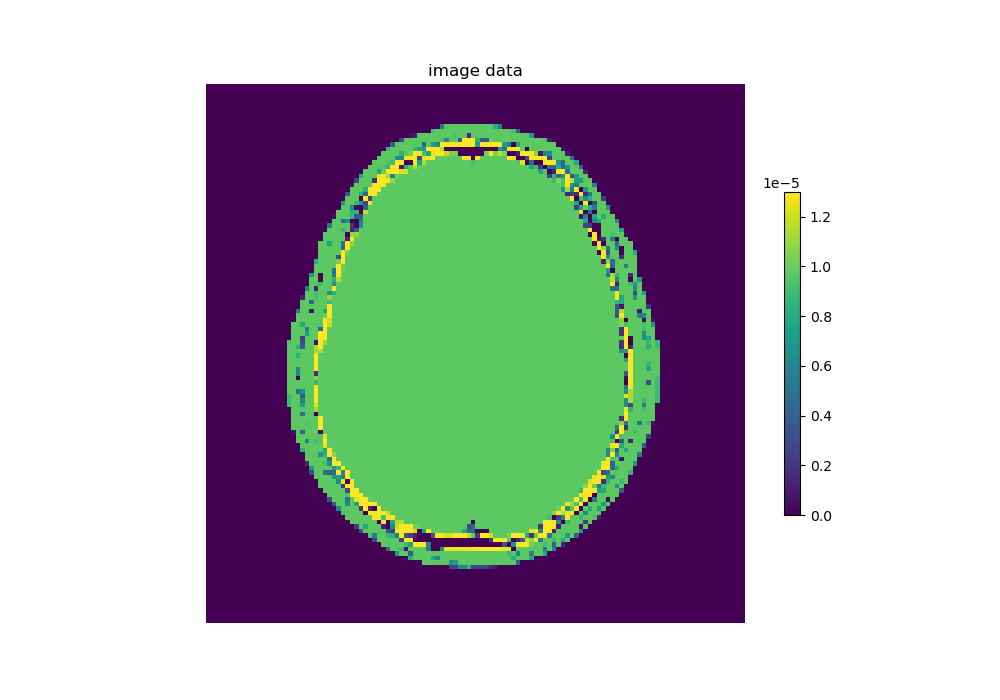

In [32]:
# Create a new figure
plt.figure()

# Display the slice (numpy.absolute is only necessary for MR but doesn't matter for PET or CT)
plot_2d_image([1,1,1], numpy.absolute(image_array[centre[0], :, :]), 'image data', cmap="viridis")

Some other things to do with ImageData objects

In [33]:
print(image_data_object.norm())

0.0062766485


In [34]:
another_image=image_data_object*3+8.3
and_another=another_image+image_data_object